In [1]:
!pip install bitsandbytes

In [2]:
import torch
import random
import numpy as np
import wandb
from torch.utils.data import Dataset
import os
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,AutoModel,BitsAndBytesConfig,Trainer, TrainingArguments,set_seed
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,roc_auc_score
from transformers.modeling_outputs import SequenceClassifierOutput
import shap
from sklearn.decomposition import PCA

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.6.0+cu124
12.4
True
1


In [3]:
wandb.login()

wandb: Currently logged in as: e274028 (e274028-metu-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
"""
import zipfile
import os

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")
"""

'\nimport zipfile\nimport os\n\nwith zipfile.ZipFile("dataset.zip", \'r\') as zip_ref:\n    zip_ref.extractall("dataset")\n'

In [5]:
def set_seed_function(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
set_seed_function(42)

In [6]:
def parse_reviews_to_dataframe(dataset_dir):
    records = []

    for year_dir in os.listdir(dataset_dir):
        year_path = os.path.join(dataset_dir, year_dir)
        if not os.path.isdir(year_path):
            continue

        review_dir = os.path.join(year_path, f"{year_dir}_review")
        if not os.path.exists(review_dir):
            continue

        for fname in os.listdir(review_dir):
            if not (fname.endswith(".json") and "ICLR" in fname):
                continue

            file_path = os.path.join(review_dir, fname)
            with open(file_path, "r") as f:
                try:
                    data = json.load(f)
                except Exception as e:
                    print(f"Failed to parse {file_path}: {e}")
                    continue

            paper_id = data.get("id", fname.replace(".json", ""))
            meta_review = data.get("metaReview", "")
            reviews = data.get("reviews", [])

            review_texts = []
            rating_scores = []

            for review in reviews:
                review_text = review.get("review", "")
                rating_raw = review.get("rating", "")
                try:
                    rating_score = int(rating_raw.split(":")[0].strip())
                    rating_scores.append(rating_score)
                except Exception as e:
                    print(f"Invalid rating. Error is e: {e}")

                review_texts.append(review_text)

            #full_text = " ".join(review_texts + [meta_review]).strip()
            avg_rating = sum(rating_scores) / len(rating_scores)
            label = 1 if avg_rating >= 6 else 0

            records.append({
                "paper_id": paper_id,
                "text": meta_review,
                "avg_rating": avg_rating,
                "label": label
            })

    return pd.DataFrame(records)

# Example usage:
df = parse_reviews_to_dataframe("dataset/dataset")
print(df.head())

        paper_id text  avg_rating  label
0  ICLR_2017_328         6.250000      1
1   ICLR_2017_36         6.000000      1
2   ICLR_2017_32         7.666667      1
3  ICLR_2017_100         8.000000      1
4  ICLR_2017_472         6.000000      1


In [7]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [8]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True, padding_side="right")
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
class ReviewDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=1024):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        encoding = self.tokenizer(
            item["text"],
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }


In [10]:
train_dataset = ReviewDataset(train_df, tokenizer)
val_dataset = ReviewDataset(val_df, tokenizer)
test_dataset = ReviewDataset(test_df, tokenizer)

In [11]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model = AutoModel.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average="binary", zero_division=0
    )
    acc = accuracy_score(labels, predictions)

    metrics = {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

    if logits.shape[1] == 2:
        try:
            probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()
            auc = roc_auc_score(labels, probs)
            metrics["auc"] = auc
        except Exception as e:
            print(f"Warning: AUC calculation failed: {e}")

    return metrics
# to do: remove shap from the function
def sweep_train():
    wandb.init()
    config = wandb.config

    # === Define target modules ===
    target_modules = []
    for i in range(12, 22):
        target_modules.append(f"layers.{i}.self_attn.q_proj")
        target_modules.append(f"layers.{i}.self_attn.v_proj")

    # === LoRA Config with last layers only ===
    peft_config = LoraConfig(
        task_type="SEQ_CLS",
        r=config.r,
        lora_alpha=16,
        lora_dropout=config.lora_dropout,
        bias="none",
        inference_mode=False,
        target_modules=target_modules
    )

    # === Load Quantized Base Model ===
    base_model = AutoModel.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto"
    )

    # === Apply LoRA adapters ===
    base_model = get_peft_model(base_model, peft_config)
    """
    # === Print LoRA trainable params ===
    print("Trainable LoRA parameters:")
    for name, param in base_model.named_parameters():
        if param.requires_grad:
            print(" -", name)
    """

    # === Wrap with classification head ===
    class QuantizedClassifier(torch.nn.Module):
        def __init__(self, base_model, hidden_size=2048, num_labels=2):
            super().__init__()
            self.base = base_model
            self.classifier = torch.nn.Linear(hidden_size, num_labels)

        def forward(self, input_ids, attention_mask=None, labels=None):
            outputs = self.base(input_ids=input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state
            pooled = (last_hidden * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)
            logits = self.classifier(pooled)
            loss = None
            if labels is not None:
                loss_fn = torch.nn.CrossEntropyLoss()
                loss = loss_fn(logits, labels)
            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states if hasattr(outputs, "hidden_states") else None,
                attentions=outputs.attentions if hasattr(outputs, "attentions") else None,
            )

    model = QuantizedClassifier(base_model, hidden_size=2048, num_labels=2)


    # Training setup
    training_args = TrainingArguments(
        output_dir="./results",
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=10,
        logging_dir="./logs",
        logging_steps=100,
        save_steps=500,
        save_total_limit=1,
        save_strategy="epoch",
        fp16=True,
        report_to="wandb",
        run_name="term-project"
    )


    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    eval_results = trainer.evaluate(eval_dataset=test_dataset)
    print("Test Set Evaluation:", eval_results)
    wandb.log(eval_results)

    sample_df = test_df.sample(n=10, random_state=42)
    texts = sample_df["text"].tolist()

    def get_pooled_embedding(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=1024).to(next(model.parameters()).device)
        with torch.no_grad():
            outputs = model.base(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
            last_hidden = outputs.last_hidden_state
            pooled = (last_hidden * inputs["attention_mask"].unsqueeze(-1)).sum(1) / inputs["attention_mask"].sum(1, keepdim=True)
        return pooled.detach().cpu()

    pooled_batch = torch.cat([get_pooled_embedding(text) for text in texts], dim=0)

    def predict_fn(x):
        with torch.no_grad():
            logits = model.classifier(torch.tensor(x, dtype=torch.float32).to(model.classifier.weight.device))
            return torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

    explainer = shap.KernelExplainer(predict_fn, pooled_batch.numpy())
    shap_values = explainer.shap_values(pooled_batch.numpy(), nsamples=100)

    # Check shape of shap_values
    if isinstance(shap_values, list):
        shap_matrix = shap_values[1]  # for class 1
    else:
        shap_matrix = shap_values  # single-class output
    shap.summary_plot(shap_matrix, pooled_batch.numpy(), feature_names=[f"F{i}" for i in range(pooled_batch.shape[1])])

Create sweep with ID: qbl5xtwz
Sweep URL: https://wandb.ai/e274028-metu-middle-east-technical-university/tinyllama-lora/sweeps/qbl5xtwz


wandb: Agent Starting Run: dr73j52u with config:
wandb: 	learning_rate: 2e-05
wandb: 	lora_dropout: 0.05
wandb: 	r: 4


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.675600
200,0.584800
300,0.556800
400,0.482800
500,0.447200
600,0.597100
700,0.445100
800,0.492400
900,0.542400
1000,0.501800


Test Set Evaluation: {'eval_loss': 0.6585779786109924, 'eval_accuracy': 0.8301158301158301, 'eval_precision': 0.7872340425531915, 'eval_recall': 0.6568047337278107, 'eval_f1': 0.7161290322580646, 'eval_auc': 0.8884386497346604, 'eval_runtime': 12.2895, 'eval_samples_per_second': 42.15, 'eval_steps_per_second': 10.578, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=8.595e-02, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

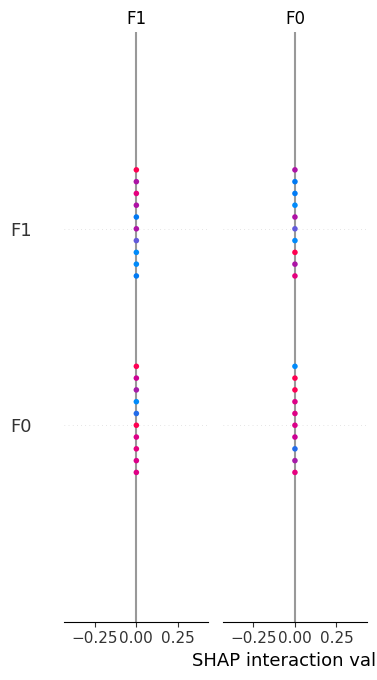

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


wandb: Agent Starting Run: azs4byhl with config:
wandb: 	learning_rate: 2e-05
wandb: 	lora_dropout: 0.05
wandb: 	r: 8


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.696600
200,0.584900
300,0.570800
400,0.496900
500,0.459100
600,0.582300
700,0.448300
800,0.474100
900,0.542200
1000,0.489300


Test Set Evaluation: {'eval_loss': 0.6708391308784485, 'eval_accuracy': 0.8359073359073359, 'eval_precision': 0.795774647887324, 'eval_recall': 0.6686390532544378, 'eval_f1': 0.7266881028938906, 'eval_auc': 0.8891253115410048, 'eval_runtime': 12.2882, 'eval_samples_per_second': 42.154, 'eval_steps_per_second': 10.579, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.068e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

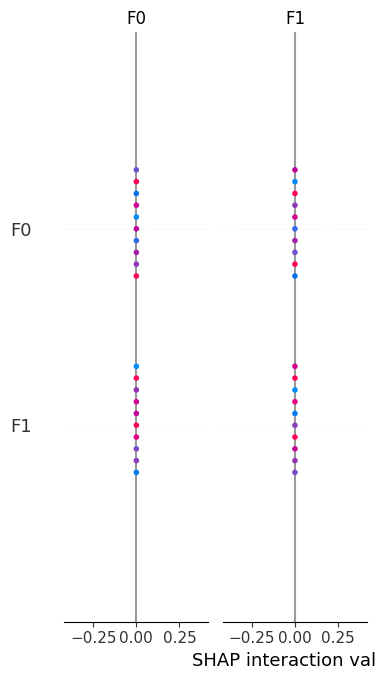

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


wandb: Agent Starting Run: lw63q9fr with config:
wandb: 	learning_rate: 2e-05
wandb: 	lora_dropout: 0.1
wandb: 	r: 4


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.663900
200,0.581200
300,0.583500
400,0.482800
500,0.467800
600,0.607600
700,0.459900
800,0.490000
900,0.565100
1000,0.509200


Test Set Evaluation: {'eval_loss': 0.7219352126121521, 'eval_accuracy': 0.806949806949807, 'eval_precision': 0.7482014388489209, 'eval_recall': 0.6153846153846154, 'eval_f1': 0.6753246753246753, 'eval_auc': 0.8821484884962953, 'eval_runtime': 12.3315, 'eval_samples_per_second': 42.006, 'eval_steps_per_second': 10.542, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=5.231e-02, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

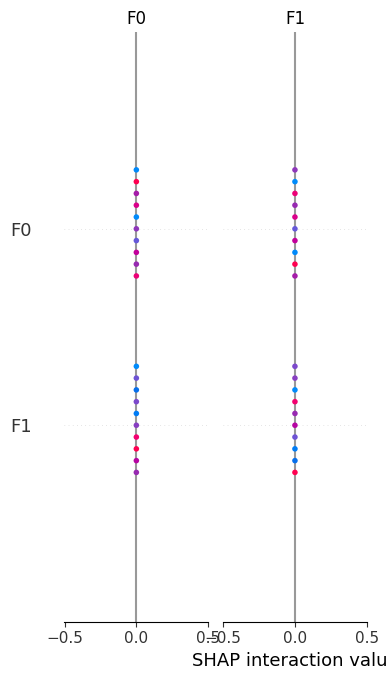

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


wandb: Agent Starting Run: vodisk2h with config:
wandb: 	learning_rate: 2e-05
wandb: 	lora_dropout: 0.1
wandb: 	r: 8


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.696700
200,0.585000
300,0.570900
400,0.496700
500,0.458900
600,0.581900
700,0.448500
800,0.474100
900,0.543100
1000,0.490000


Test Set Evaluation: {'eval_loss': 0.6707870364189148, 'eval_accuracy': 0.832046332046332, 'eval_precision': 0.7887323943661971, 'eval_recall': 0.6627218934911243, 'eval_f1': 0.7202572347266881, 'eval_auc': 0.8884640816534138, 'eval_runtime': 12.2908, 'eval_samples_per_second': 42.145, 'eval_steps_per_second': 10.577, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.158e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

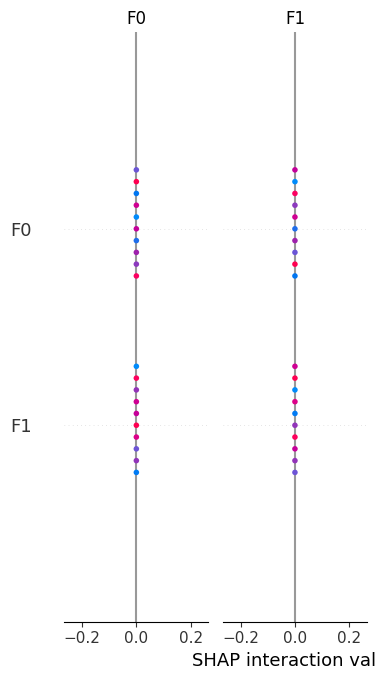

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


wandb: Agent Starting Run: cxxq9kik with config:
wandb: 	learning_rate: 3e-05
wandb: 	lora_dropout: 0.05
wandb: 	r: 4


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.663800
200,0.581100
300,0.582400
400,0.480600
500,0.465000
600,0.607400
700,0.457500
800,0.488500
900,0.562400
1000,0.509300


Test Set Evaluation: {'eval_loss': 0.7361297011375427, 'eval_accuracy': 0.8166023166023166, 'eval_precision': 0.7720588235294118, 'eval_recall': 0.621301775147929, 'eval_f1': 0.6885245901639344, 'eval_auc': 0.8823943303775791, 'eval_runtime': 12.3144, 'eval_samples_per_second': 42.065, 'eval_steps_per_second': 10.557, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.003e-01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

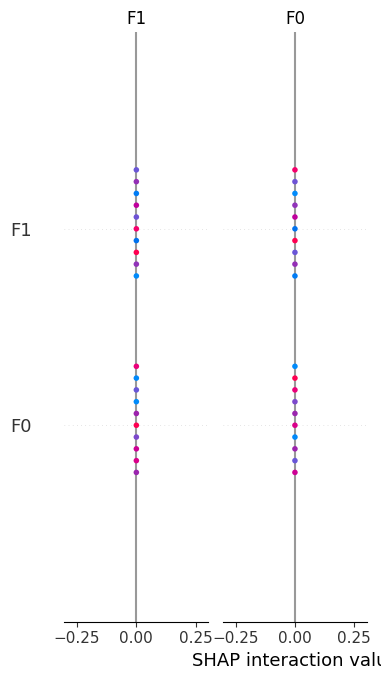

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


wandb: Agent Starting Run: m09tvyzw with config:
wandb: 	learning_rate: 3e-05
wandb: 	lora_dropout: 0.05
wandb: 	r: 8


/tmp/ipython-input-12-3104843866.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).


Step,Training Loss
100,0.696600
200,0.584900
300,0.570800
400,0.497000
500,0.459100
600,0.582400
700,0.448300
800,0.474100
900,0.542200
1000,0.489200


Test Set Evaluation: {'eval_loss': 0.6709284782409668, 'eval_accuracy': 0.8359073359073359, 'eval_precision': 0.795774647887324, 'eval_recall': 0.6686390532544378, 'eval_f1': 0.7266881028938906, 'eval_auc': 0.8891253115410048, 'eval_runtime': 12.2718, 'eval_samples_per_second': 42.211, 'eval_steps_per_second': 10.593, 'epoch': 10.0}


  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=8.079e-02, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 

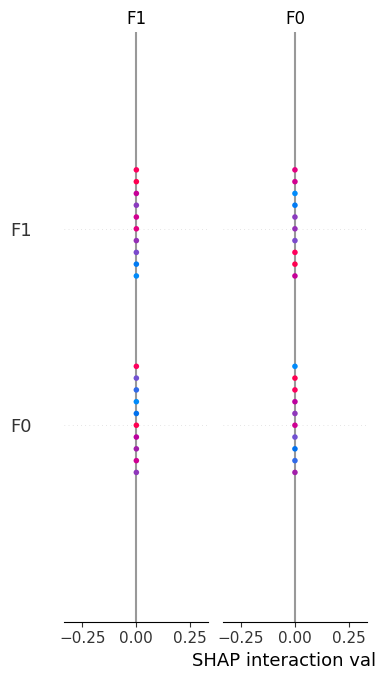

epoch,▁
eval/accuracy,▁
eval/auc,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_accuracy,▁


In [13]:
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "eval/accuracy",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {"values": [2e-5, 3e-5]},
        "r": {"values": [4, 8]},
        "lora_dropout": {"values": [0.05, 0.1]}
    }
}

sweep_id = wandb.sweep(sweep_config, project="tinyllama-lora")
wandb.agent(sweep_id, function=sweep_train, count=6)